### Import Libraries

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from shutil import copyfile
from pathlib import Path
from tqdm.notebook import tqdm

from ultralytics import YOLO

from prohibited_detection.prohibited_detector import ProhibitedDetector

### Initialize

In [ ]:
os.chdir("..")

In [12]:
random.seed(42)

### Utility Functions

In [2]:
def show_image(image: np.ndarray, figsize: tuple = (6, 4)):
    if image is None:
        print("Error: Cannot load image. Please check the file path.")
    else:
        print(f"Image loaded successfully. Shape: {image.shape}")

    plt.figure(figsize = figsize)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

In [3]:
def annotate(image: np.ndarray, boxes: list, labels: list, confidences: list, color: tuple = (0, 255, 0)) -> np.ndarray:
    annotated_image = image.copy()

    for box, label, confidence in zip(boxes, labels, confidences):
        x0, y0, x1, y1 = map(int, box)
        text = f"{label} {confidence}"
        cv2.rectangle(annotated_image, (x0, y0), (x1, y1), color, 3)

        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.8
        font_thickness = 2
        (text_w, text_h), baseline = cv2.getTextSize(text, font, font_scale, font_thickness)

        cv2.rectangle(
            annotated_image,
            (x0, y0 - text_h - baseline - 4),
            (x0 + text_w + 4, y0),
            color,
            -1
        )

        cv2.putText(
            annotated_image,
            text,
            (x0 + 2, y0 - 4),
            font,
            font_scale,
            (255, 255, 255),
            font_thickness,
            lineType = cv2.LINE_AA
        )

    return annotated_image

### Export Model

In [ ]:
model = YOLO("models/best.onnx", task = "detect")

In [34]:
model.export(format = "onnx", imgsz = 512, simplify = True, nms = True, dynamic = False, opset = 19)

Ultralytics 8.3.223  Python-3.10.4 torch-2.5.1+cu121 CPU (AMD Ryzen 7 5800H with Radeon Graphics)



PyTorch: starting from 'models\best_2.pt' with input shape (1, 3, 512, 512) BCHW and output shape(s) (1, 300, 6) (18.3 MB)

ONNX: starting export with onnx 1.19.1 opset 19...
ONNX: slimming with onnxslim 0.1.72...
ONNX: export success  2.1s, saved as 'models\best_2.onnx' (36.2 MB)

Export complete (2.4s)
Results saved to D:\passa\coding\Projects\dl-final-project\models
Predict:         yolo predict task=detect model=models\best_2.onnx imgsz=512  
Validate:        yolo val task=detect model=models\best_2.onnx imgsz=512 data=/content/data.yaml  
Visualize:       https://netron.app


'models\\best_2.onnx'

### Evaluate

In [ ]:
prohibited_detector = ProhibitedDetector(model_path = "models/best.onnx")

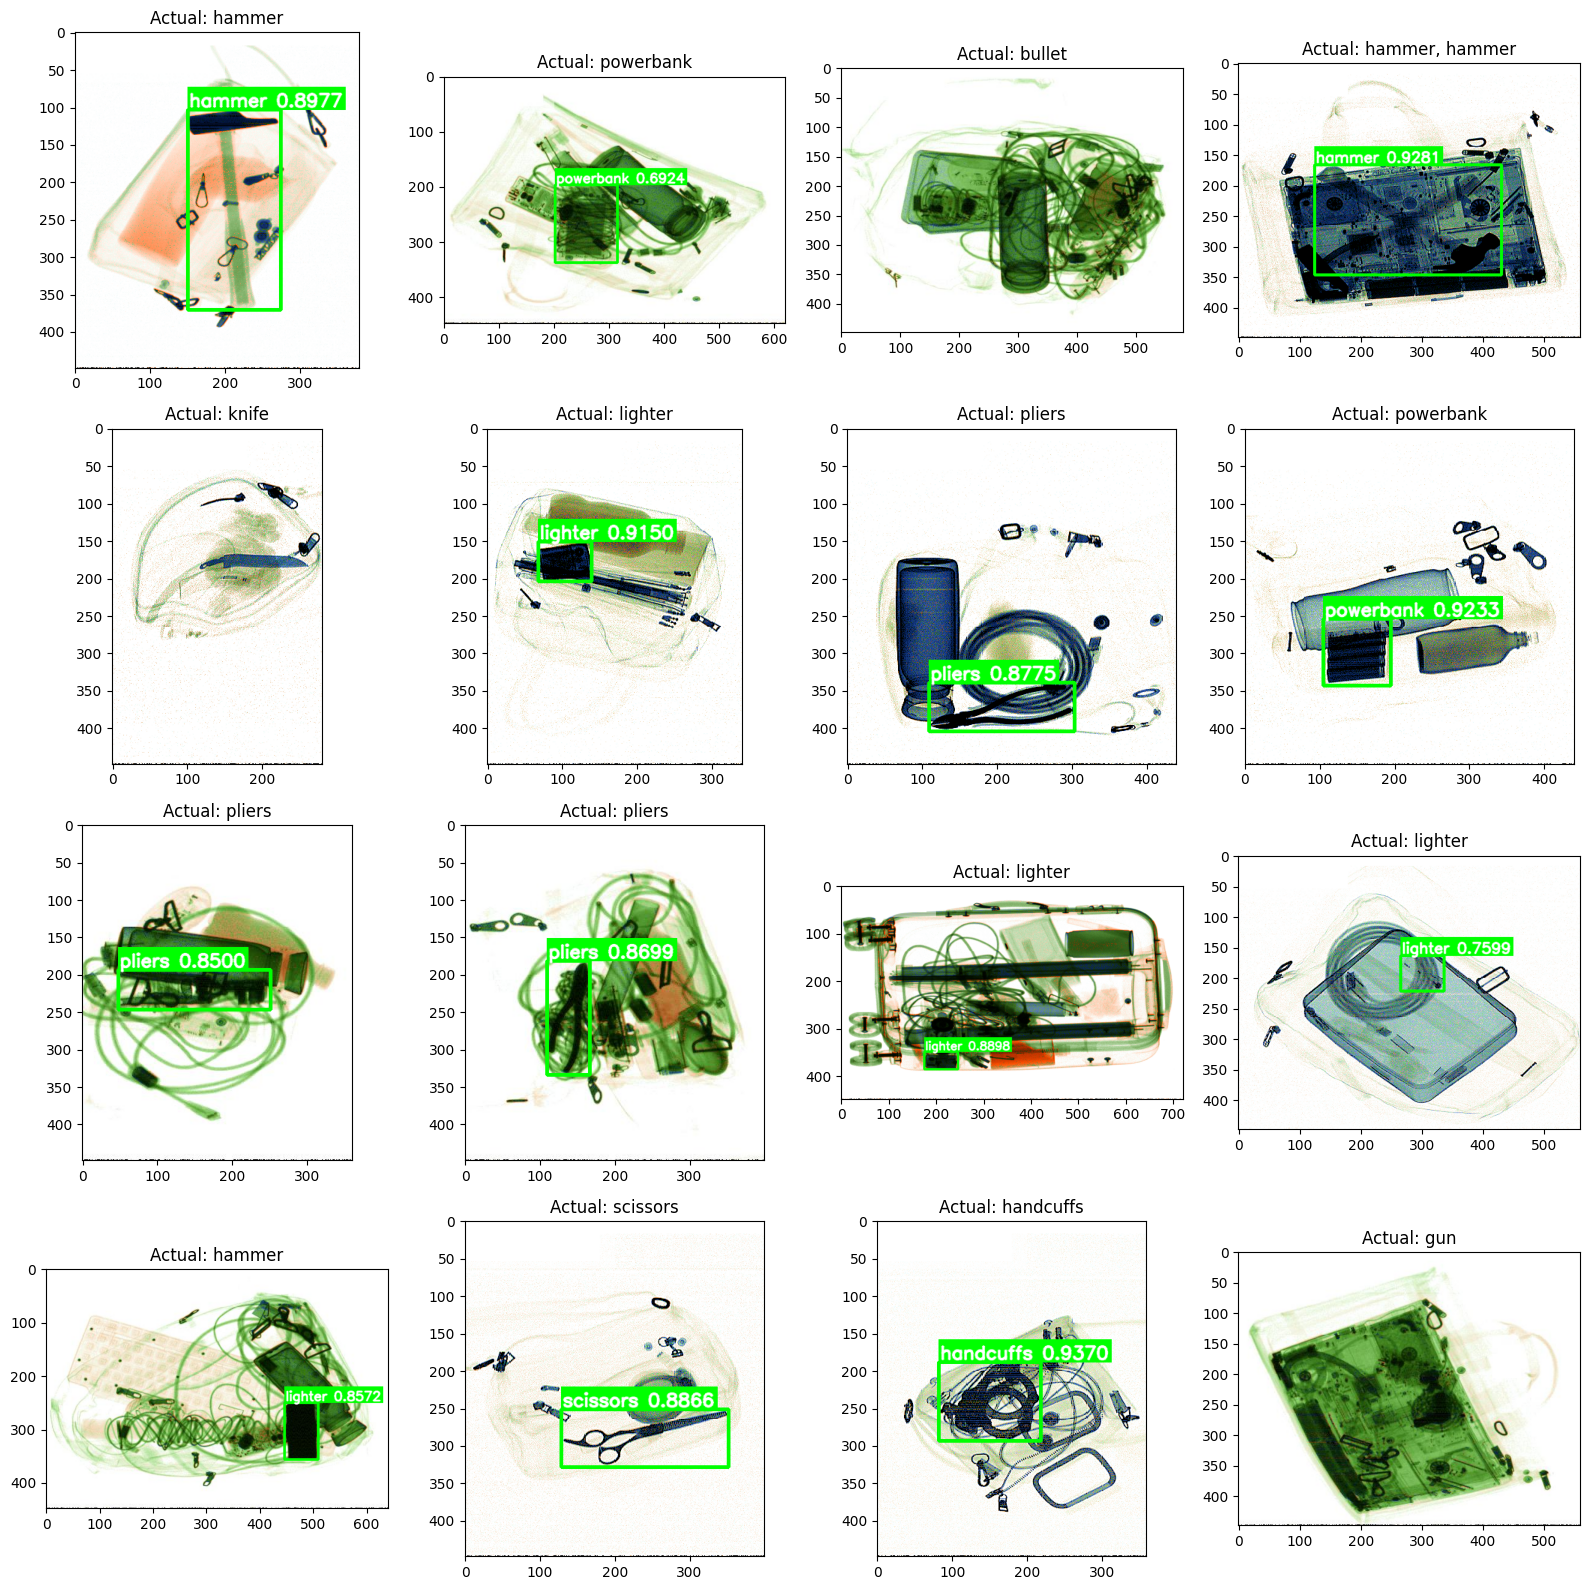

In [25]:
test_image_dir = Path("dataset/images/test")
test_label_dir = Path("dataset/labels/test")

samples = []

for image_path in test_image_dir.iterdir():
    label_path = test_label_dir / (image_path.stem + ".txt")

    labels = [] 
    with open(label_path, mode = "r", encoding = "utf-8") as f:
        lines = f.read().splitlines()

        for line in lines:
            class_index = int(line.split()[0])
            labels.append(prohibited_detector.class_names[class_index])

    if len(labels) > 0:
        samples.append((image_path, labels))

random.shuffle(samples)

fig, axes = plt.subplots(4, 4, figsize = (16, 16))
axes = axes.flatten()

for ax, (image_path, actual_labels) in zip(axes, samples[:16]):
    image = cv2.imread(str(image_path))
    detections = prohibited_detector.predict(image, conf = 0.5)

    boxes, labels, confidences = [], [], []

    for detection in detections:
        x0, y0, x1, y1 = detection["box"].values()
        label = detection["label"]
        confidence = detection["confidence"]

        labels.append(label)
        boxes.append((x0, y0, x1, y1))
        confidences.append(confidence)

    annotated_image = annotate(image, boxes, labels, confidences)
    ax.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))

    title = f"Actual: {', '.join(actual_labels)}"
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [47]:
source_dir = Path("dataset")
dest_dir = Path("testing_set")

source_image_dir = source_dir / "images" / "test"
source_label_dir = source_dir / "labels" / "test"
dest_image_dir = dest_dir / "images"
dest_label_dir = dest_dir / "labels"

image_paths = [f for f in source_image_dir.iterdir() if f.is_file()]

for image_path in tqdm(image_paths, desc = "Copying files", unit = "file", ncols = 1000):
    difficulty = image_path.stem.split("_")[1]

    label_path = source_label_dir / (image_path.stem + ".txt")

    dest_image_difficulty_dir = dest_image_dir / difficulty
    dest_label_difficulty_dir = dest_label_dir / difficulty

    dest_image_difficulty_dir.mkdir(parents = True, exist_ok = True)
    dest_label_difficulty_dir.mkdir(parents = True, exist_ok = True)

    dest_image_path = dest_image_difficulty_dir / image_path.name
    dest_label_path = dest_label_difficulty_dir / label_path.name

    copyfile(image_path, dest_image_path)
    copyfile(label_path, dest_label_path)

Copying files:   0%|                                                                                          …

In [48]:
model = YOLO("models/best.onnx", task = "detect")

In [ ]:
easy_metrics = model.val(
    data = "data/easy.yaml",
    split = "test",
    imgsz = 512,
    name = "easy"
)

Ultralytics 8.3.223  Python-3.10.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Loading models/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 CUDAExecutionProvider
Setting batch=1 input of shape (1, 3, 512, 512)
val: Fast image access  (ping: 0.10.1 ms, read: 2029.4546.1 MB/s, size: 319.6 KB)
val: Scanning D:\passa\coding\Projects\dl-final-project\testing_set\labels\easy.cache... 2623 images, 1636 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2623/2623  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2623/2623 70.1it/s 37.4s<0.0s
                   all       2623        987      0.779      0.818      0.838      0.773
                 baton         33         33      0.971          1      0.995      0.961
                pliers         92         92      0.939          1      0.989      0.959
                hammer        129        129      0.976       0.93      0.964      0.947

In [ ]:
hard_metrics = model.val(
    data = "data/hard.yaml",
    split = "test",
    imgsz = 512,
    name = "hard"
)

Ultralytics 8.3.223  Python-3.10.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Loading models/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 CUDAExecutionProvider
Setting batch=1 input of shape (1, 3, 512, 512)
val: Fast image access  (ping: 0.10.0 ms, read: 1964.6601.4 MB/s, size: 422.4 KB)
val: Scanning D:\passa\coding\Projects\dl-final-project\testing_set\labels\hard.cache... 1025 images, 623 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1025/1025 1.0Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1025/1025 67.3it/s 15.2s0.1s
                   all       1025        950      0.912      0.811      0.875      0.763
                 baton         27         30       0.96      0.933       0.96       0.82
                pliers        107        118      0.969      0.983      0.989      0.889
                hammer         80         90      0.963      0.869       0.93     

In [ ]:
hidden_metrics = model.val(
    data = "data/hidden.yaml",
    split = "test",
    imgsz = 512,
    name = "hidden"
)

Ultralytics 8.3.223  Python-3.10.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Loading models/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 CUDAExecutionProvider
Setting batch=1 input of shape (1, 3, 512, 512)
val: Fast image access  (ping: 0.10.0 ms, read: 900.71516.3 MB/s, size: 220.6 KB)
val: Scanning D:\passa\coding\Projects\dl-final-project\testing_set\labels\hidden.cache... 1352 images, 846 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1352/1352  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1352/1352 67.6it/s 20.0s<0.1s
                   all       1352        506      0.844      0.615      0.761      0.654
                 baton         23         23      0.597      0.522      0.577       0.49
                pliers         62         62      0.931      0.839      0.908      0.808
                hammer         51         51      0.972      0.669      0.892      0.74

In [ ]:
overall_metrics = model.val(
    data = "data/test.yaml",
    split = "test",
    imgsz = 512,
    name = "overall"
)

Ultralytics 8.3.223  Python-3.10.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Loading models/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 CUDAExecutionProvider
Setting batch=1 input of shape (1, 3, 512, 512)
val: Fast image access  (ping: 0.10.0 ms, read: 1973.9509.4 MB/s, size: 327.9 KB)
val: Scanning D:\passa\coding\Projects\dl-final-project\dataset\labels\test.cache... 5000 images, 3105 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 5000/5000  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5000/5000 70.0it/s 1:11<0.0ss
                   all       5000       2443      0.854      0.768      0.847      0.756
                 baton         83         86      0.804      0.872      0.901      0.814
                pliers        261        272      0.946      0.956      0.972        0.9
                hammer        260        270      0.975      0.874      0.941      0.891
   

In [150]:
all_metrics = [easy_metrics, hard_metrics, hidden_metrics, overall_metrics]
metrics_names = ["easy", "hard", "hidden", "overall"]
rows = []

for metrics_name, metrics in zip(metrics_names, all_metrics):
    num_images = sum(class_summary["Images"] for class_summary in metrics.summary())
    num_instances = sum(class_summary["Instances"] for class_summary in metrics.summary())

    box = metrics.box
    box_map50 = f"{float(box.map50) * 100:.2f}"
    box_map75 = f"{float(box.map75) * 100:.2f}"
    box_map = f"{float(box.map) * 100:.2f}"

    rows.append([metrics_name, num_images, num_instances, box_map50, box_map75, box_map])

map_df = pd.DataFrame(rows, columns = ["Dataset", "Images", "Instances", "mAP50", "mAP75", "mAP50-95"])

print(map_df)

   Dataset  Images  Instances  mAP50  mAP75 mAP50-95
0     easy     987        987  83.76  81.50    77.32
1     hard     825        950  87.52  82.06    76.34
2   hidden     506        506  76.10  72.61    65.42
3  overall    2318       2443  84.66  81.16    75.63


In [153]:
summary = []

for class_summary in overall_metrics.summary():
    row = {}
    row["Class"] = class_summary["Class"]
    row["Images"] = class_summary["Images"]
    row["Instances"] = class_summary["Instances"]
    row["Precision"] = f"{class_summary['Box-P'] * 100:.2f}"
    row["Recall"] = f"{class_summary['Box-R'] * 100:.2f}"
    row["F1"] = f"{class_summary['Box-F1'] * 100:.2f}"
    row["mAP50"] = f"{class_summary['mAP50'] * 100:.2f}"
    row["mAP50-95"] = f"{class_summary['mAP50-95'] * 100:.2f}"
    
    summary.append(row)

summary_df = pd.DataFrame(summary)

print(summary_df)

        Class  Images  Instances Precision Recall     F1  mAP50 mAP50-95
0       baton      83         86     80.43  87.21  83.68  90.12    81.36
1      pliers     261        272     94.64  95.59  95.11  97.23    89.96
2      hammer     260        270     97.52  87.38  92.17  94.10    89.06
3   powerbank     294        311     86.18  89.71  87.91  94.50    80.68
4    scissors     259        293     76.97  89.08  82.58  90.41    79.68
5      wrench     217        226     94.40  96.90  95.63  97.72    92.15
6         gun     151        165     81.05  28.51  42.19  54.20    43.08
7      bullet     129        130     76.24  70.00  72.99  76.94    67.39
8     sprayer     113        116     95.41  71.66  81.85  87.95    77.39
9   handcuffs     139        139     98.61  98.56  98.58  99.08    93.69
10      knife     214        237     70.24  38.83  50.02  58.59    48.24
11    lighter     198        198     72.85  68.69  70.71  75.02    64.90


In [155]:
print(map_df.to_markdown(index = False))

| Dataset   |   Images |   Instances |   mAP50 |   mAP75 |   mAP50-95 |
|:----------|---------:|------------:|--------:|--------:|-----------:|
| easy      |      987 |         987 |   83.76 |   81.5  |      77.32 |
| hard      |      825 |         950 |   87.52 |   82.06 |      76.34 |
| hidden    |      506 |         506 |   76.1  |   72.61 |      65.42 |
| overall   |     2318 |        2443 |   84.66 |   81.16 |      75.63 |


In [156]:
print(summary_df.to_markdown(index = False))

| Class     |   Images |   Instances |   Precision |   Recall |    F1 |   mAP50 |   mAP50-95 |
|:----------|---------:|------------:|------------:|---------:|------:|--------:|-----------:|
| baton     |       83 |          86 |       80.43 |    87.21 | 83.68 |   90.12 |      81.36 |
| pliers    |      261 |         272 |       94.64 |    95.59 | 95.11 |   97.23 |      89.96 |
| hammer    |      260 |         270 |       97.52 |    87.38 | 92.17 |   94.1  |      89.06 |
| powerbank |      294 |         311 |       86.18 |    89.71 | 87.91 |   94.5  |      80.68 |
| scissors  |      259 |         293 |       76.97 |    89.08 | 82.58 |   90.41 |      79.68 |
| wrench    |      217 |         226 |       94.4  |    96.9  | 95.63 |   97.72 |      92.15 |
| gun       |      151 |         165 |       81.05 |    28.51 | 42.19 |   54.2  |      43.08 |
| bullet    |      129 |         130 |       76.24 |    70    | 72.99 |   76.94 |      67.39 |
| sprayer   |      113 |         116 |       95.41